<h1 align="center"> Relationship of personality traits with the probability of being employed in Poland</h1>

<h5 align="center">Natalia Graczyk</h5>

The analysis below is part of my master's thesis defended at University of Warsaw in June 2022.

## Abstract

The current challenges of the labour market require a thorough analysis of factors related to the probability of employment of individuals. This paper presents the most important theories related to the labour market, such as the Search and Matching Theory, the Human Capital Theory and the Statistical Discrimination Theory. With reference to the psychological aspect of this paper, the most well-known theory on personality traits of individuals, which is The Big Five Theory, was presented as well.
 
In the empirical part of this paper, based on the data from the PIAAC and post-PIAAC studies, logit model was estimated, aiming at examinating the relationship of personality traits with the probability of employment in Poland. The results showed that differences in respondents' personalities were related to the probability of employment.

In [6649]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
import warnings
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
import plotly.express as px
import textwrap
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from  statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import norm


In [6584]:
with warnings.catch_warnings():
     warnings.filterwarnings('ignore')

## Data

The analysis was performed based on individual-derived data from the PIAAC study (Programme for the International Assessment of Adult Competencies) for Poland, as well as its national follow-up (post-PIAAC), in which additional information was collected from people participating in the first edition of the study. The PIAAC survey was conducted among randomly selected individuals aged 16-65 years living in Poland during the period of data collection for the survey, i.e. 2011-2012. The postPIAAC survey population consisted of participants in the first edition of the survey (PIAAC), living in Poland between October 2014 and February 2015. 

This particular data was chosen because it is the only study on the situation of Poles in the labor market that provides not only information about the cognitive skills of respondents, but also their personality traits.

The relationship of personality traits with the probability of employment will be estimated using logistic regression model in which the employment status during post-PIAAC study is the dependent variable and takes the values of 1 in case of being employed and 0 in case of being unemployed or professionally inactive during that period. It was decided to use the logit model because for the purposes of this study, it was important to compare the model with the results of other studies conducted in other countries.

In [6585]:
MY_PATH = os.path.join('C:', os.sep)

def fetch_data(path = MY_PATH):
    csv_path = os.path.join(path, "piaac_postpiaac_data.csv")
    return pd.read_csv(csv_path)

In [6586]:
data = fetch_data()

In [6587]:
print(f"The dataset includes {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset includes 4954 rows and 11 columns.


In [6588]:
data.head(5)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,education_field,training,employment_status
0,5.666666,3.333333,6.000000,3.666667,4.666666,23,Male,upper secondary or post-secondary education,general programmes,training in the 12 months prior to the postPIAAC,employed
1,7.000000,4.000000,4.000000,4.000000,4.000000,33,Male,basic vocational education,"engineering, manufacturing and construction",no training in the 12 months prior to the study,employed
2,5.000000,2.000000,3.333333,4.333334,3.666667,19,Male,upper secondary or post-secondary education,no education,training in the 12 months prior to the postPIAAC,employed
3,6.000000,2.666667,4.000000,3.333333,3.666667,20,Female,tertiary education,"science, mathematics and computing",no training in the 12 months prior to the study,unemployed
4,7.000000,5.000000,6.333334,5.333334,2.333333,19,Male,upper secondary or post-secondary education,no education,no training in the 12 months prior to the study,employed


The main explanatory variables on which this study focuses concern personality traits.

The Big Five personality variables were measured in the postPIAAC study using the BFI-S Abbreviated Personality Inventory. This questionnaire contains 15 statements, (three statements for each personality dimension), which are answered on a 7-point Likert scale (from 1 - 'completely disagree' to 7 - 'completely agree'). The final scores for each dimension were calculated as the average of the three statements.

In addition to personality traits variables, control variables were also included in the analysis. Based on the literature review, it was decided to include variables controlling for demographic characteristics (age, gender) and human capital variables (level of education, branch of  education and training received). 

In [6589]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   conscientiousness  4718 non-null   float64
 1   extroversion       4681 non-null   float64
 2   agreeableness      4707 non-null   float64
 3   openness           4650 non-null   float64
 4   neuroticism        4692 non-null   float64
 5   age                4954 non-null   int64  
 6   gender             4954 non-null   object 
 7   education          4954 non-null   object 
 8   education_field    4954 non-null   object 
 9   training           4954 non-null   object 
 10  employment_status  4954 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 425.9+ KB


## Exploratory Data Analysis

### Univariate analysis

Firstly, let's delve into summary statistics of the data:

In [6590]:
data.describe()

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age
count,4718.000000,4681.000000,4707.000000,4650.000000,4692.000000,4954.000000
mean,5.718737,4.083458,5.076553,5.043513,4.114379,31.563181
std,0.993417,1.096253,1.093071,1.108594,1.275235,14.054196
min,1.000000,1.000000,1.000000,1.000000,0.666667,16.000000
25%,5.000000,3.333333,4.333334,4.333334,3.333333,21.000000
50%,5.666666,4.000000,5.000000,5.000000,4.000000,25.000000
75%,6.666666,5.000000,6.000000,6.000000,5.000000,41.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,65.000000


Personality traits were measured based on 7-point Linert scale, thus it's not possible to have a minimum value of 0.7 in the neuroticism column.

In [6591]:
data[data.neuroticism < 1]

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,education_field,training,employment_status
1584,NaN,5.0,NaN,3.0,0.666667,24,Male,primary or lower secondary education,no education,no training in the 12 months prior to the study,unemployed


In [6592]:
neuroticism_outlier = data[data.neuroticism < 1]
data.drop(neuroticism_outlier.index, inplace = True)


#### Personality Traits

Let's see what's the distribution of the personality traits variables.

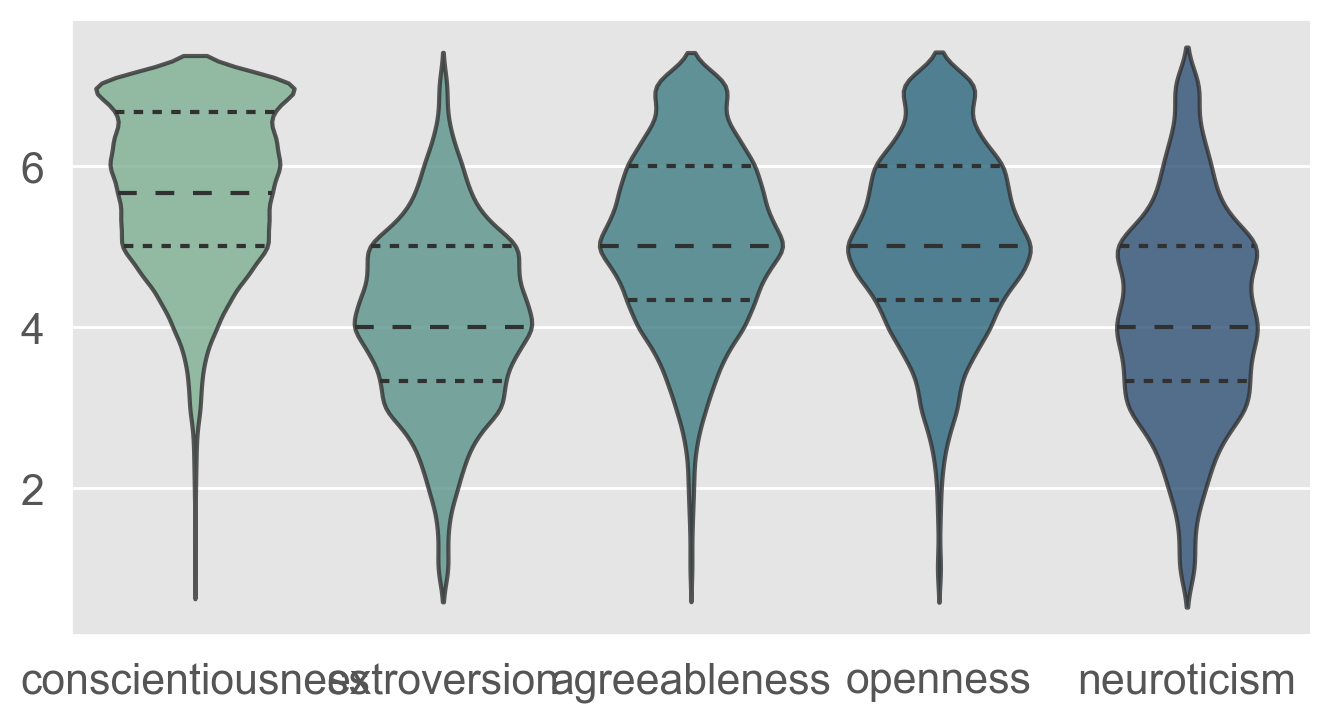

In [6593]:
plt.figure(figsize=(8,4), dpi=200)

ax = sns.violinplot(
       data = data[['conscientiousness', 'extroversion', 'agreeableness', 'openness',
       'neuroticism']],
       palette = "crest", 
       inner = "quartile")

plt.setp(ax.collections, alpha=.8)

plt.show()


The results of the personality test on the larger sample should form a normal distribution. As can be seen from the graphs, the probability density distributions for `extraversion` and `neuroticism` are close to a normal distribution, while for the traits `conscientiousness`, `agreeableness` and `openness`, a left skewness of the distributions was observed. 
In the case of `conscientiousness`, the leftward skewness is confirmed in the literature and is due to the fact that respondents often tend to give answers that are more socially desirable in relation to this trait.  



#### Age

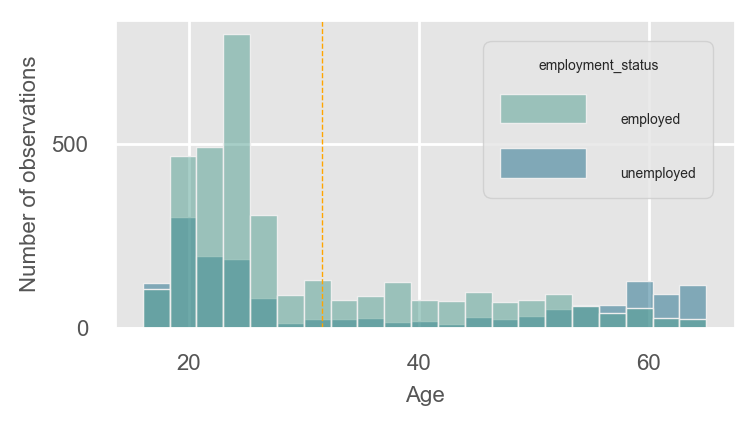

In [6594]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.histplot(
       data = data,
       x = "age",
       hue = "employment_status",
       palette = "crest")

ax.axvline(x=data.age.mean(),
            color='orange',
            linestyle = '--',
            linewidth = 0.5)

ax.set_xlabel("Age", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

plt.show()

The average age was 31. It should be noted that the Polish study chose to over-represent young people aged 19-26, the purpose of which was to enable a detailed analysis between young people's competences and educational and professional pathways.

In this part of the analysis, we will be creating countplots for categorical variables, so let's first define the necessary function for this:

In [6595]:
def create_countplot(feature, xtitle, xfontsize, xrotation = 0):
    
    plt.figure(figsize=(4,2), dpi=200)
    plt.style.use('ggplot')

    ax = sns.countplot(
        data = data,
        x = feature,
        hue = "employment_status",
        order = data[feature].value_counts().index,
        palette = "crest", 
        alpha = 0.7)

    ax.set_xlabel(xtitle, fontsize = 8)
    ax.set_ylabel("Number of observations", fontsize = 8)

    wrap_labels(ax, 12)
    ax.figure

    plt.xticks(fontsize = xfontsize, rotation = xrotation)
    plt.yticks(fontsize = 8)
    plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

    plt.show()


Let's also define a function to wrap text on x axis:

In [6596]:
# source: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

#### Gender

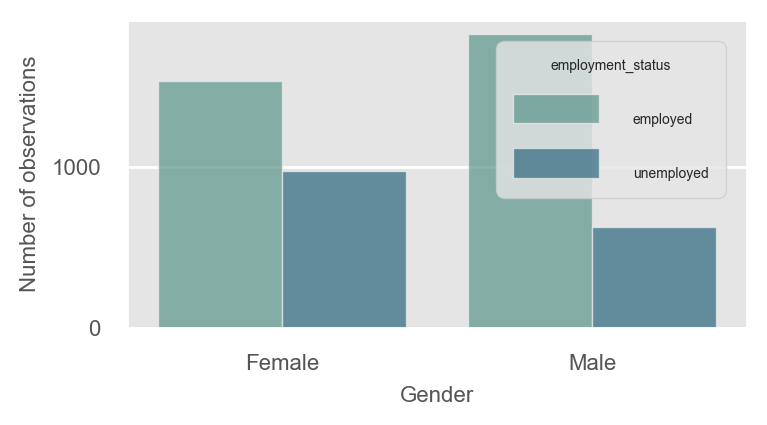

In [6597]:
create_countplot("gender", "gender".title(), 8)

In [6598]:
pd.crosstab(data["gender"], columns="count", normalize = "columns")

col_0,count
gender,
Female,0.505754
Male,0.494246


`Gender` was relatively evenly distributed in the study sample. Looking at the dependent variable (`employment_status`), it can be seen that there were more employed men than women and more unemployed women than men in the sample, which is a reasonable result due to maternity responsibilities.

#### Education

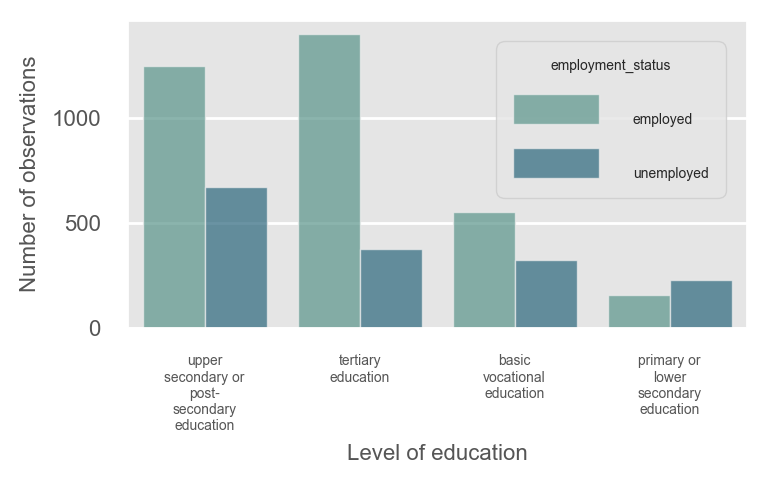

In [6599]:
create_countplot("education", "Level of education", 5)


In [6600]:
pd.crosstab(data["education"], columns="count", normalize = "columns")

col_0,count
education,
basic vocational education,0.177064
primary or lower secondary education,0.077731
tertiary education,0.358167
upper secondary or post-secondary education,0.387038


In case of the level of education, the largest proportion of respondents had upper secondary or post-secondary education. 

Among those employed, the largest proportion of respondents had tertiary education (Bachelor's or Master's degree), but there were almost as many employed respondents with upper secondary or post-secondary education. On the other hand, among those who were unemployed at this time period, the largest proportion of respondents had upper secondary or post-secondary education.

#### Field of education

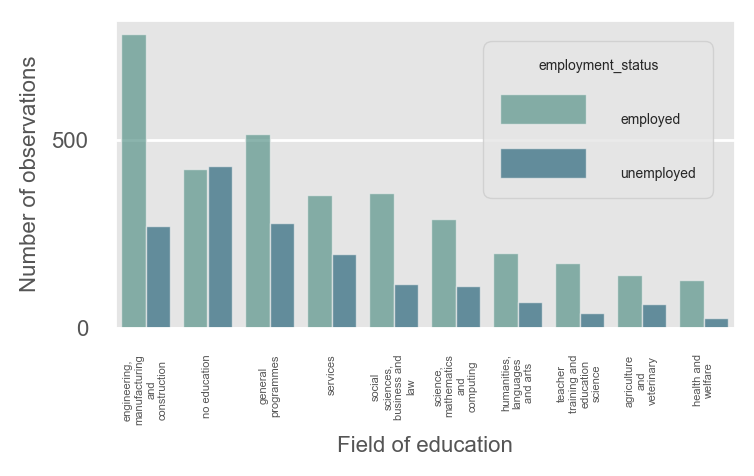

In [6601]:
create_countplot("education_field", "Field of education", 4, xrotation = 90)

In [6602]:
pd.crosstab(data["education_field"], columns="count", normalize = "columns")

col_0,count
education_field,
agriculture and veterinary,0.040581
"engineering, manufacturing and construction",0.212195
general programmes,0.160307
health and welfare,0.030688
"humanities, languages and arts",0.054109
no education,0.172017
"science, mathematics and computing",0.080759
services,0.110842
"social sciences, business and law",0.095498


Among employed respondents, the highest proportion of them had a degree in engineering, manufacturing and construction. The second most common field of education was general programmes.

On the other hand, among those unemployed, the largest proportion of respondents had no education. In the second place were general programmes and engineering, manufacturing and construction.

#### Trainings

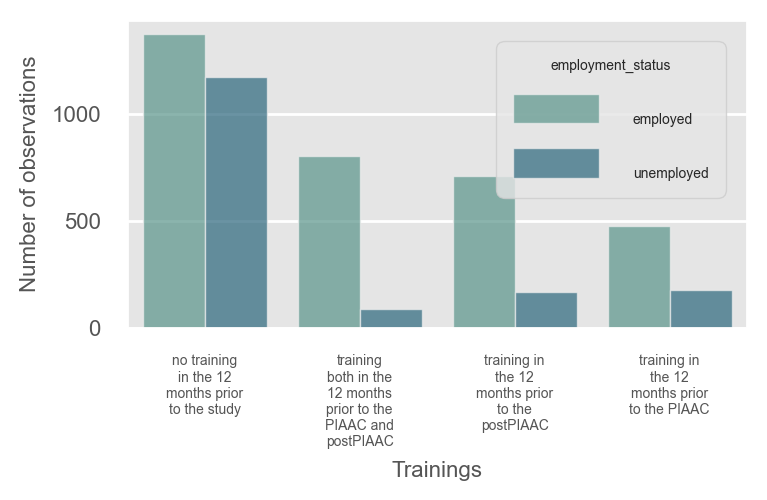

In [6603]:
create_countplot("training", "Trainings", 5)

The majority of respondents had not received any training in the two years preceding the PIAAC and postPIAAC survey. 

#### Employment status during postPIAAC study

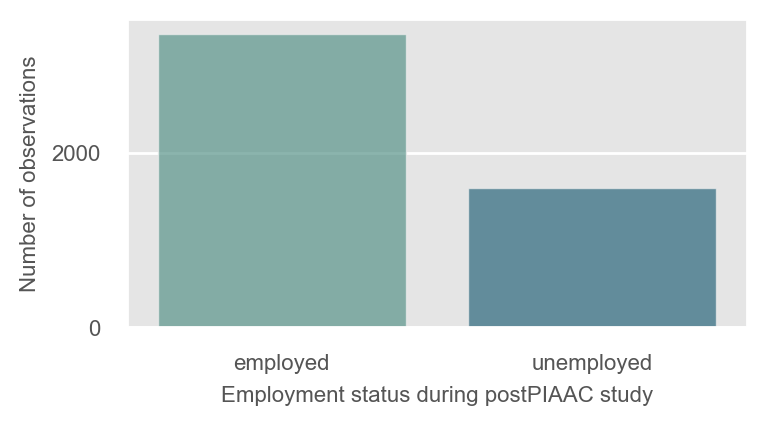

In [6604]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = data,
       x = "employment_status",
       palette = "crest", 
       alpha = 0.7)

ax.set_xlabel("Employment status during postPIAAC study", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.show()

From the above chart we can observe that there is a class imbalance, becase there are much more employed respondents in the study than those unemployed.
This will be addressed at a later stage of this analysis.

### Bivariate analysis

##### Personality Traits variables

Fristly, let's check whether the personality traits are correlated with each other by calculating a Pearson correlation coefficient.

In [6605]:
personality_cols = ['conscientiousness', 'extroversion', 'agreeableness', 'openness',
                    'neuroticism']

In [6606]:
def create_heatmap(coeff, title, v_min=None, v_max=None,set_fmt ='.2g'):

    plt.figure(figsize=(8, 4))
    heatmap = sns.heatmap(coeff, vmin=v_min, vmax=v_max, annot=True, cmap='GnBu', fmt= set_fmt)
    heatmap.set_title(title, fontdict={'fontsize':12}, pad=12)
    plt.show()

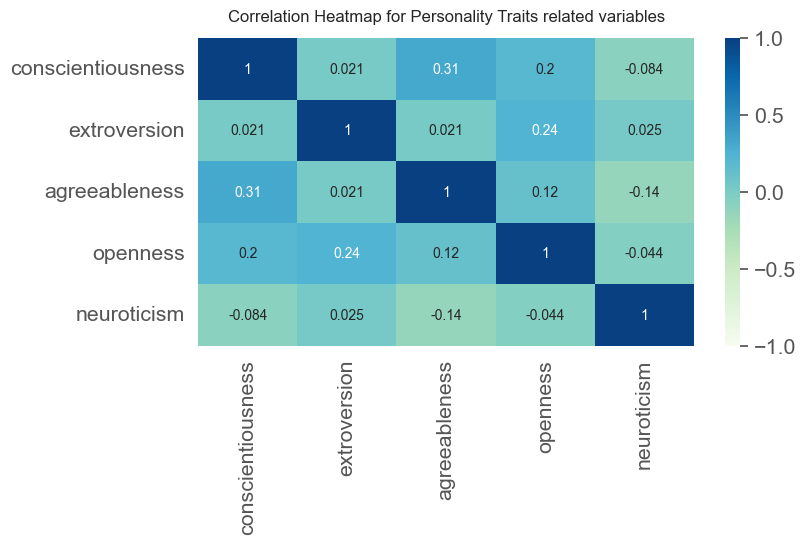

In [6607]:
create_heatmap(data[personality_cols].corr(),v_min = -1, v_max = 1, title = "Correlation Heatmap for Personality Traits related variables")

Among the Big Five characteristics, the highest moderate positive correlation can be observed for the variables `agreeableness` and `conscientiousness`, where the Pearson correlation coefficient is 0.31. A weak positive correlation can be observed for the variables `openness` and `extraversion` (with a Pearson correlation coefficient of 0.23), and `openness` and `conscientiousness` (with a Pearson correlation coefficient of 0.19).

##### Categorical variables

Now, we'll have a look at a measure of association between categorical features. In order to achieve this, the Cramer's V coefficient will be calculated.

In [6608]:
categorical_vars = data.columns[6:]
cat_data = data[categorical_vars]

In [6609]:
# source: https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [6610]:
rows=[]

for var1 in cat_data:
  col=[]
  for var2 in cat_data:
    cramers =cramers_V(cat_data[var1], cat_data[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
cramers_df = pd.DataFrame(cramers_results, columns =cat_data.columns, index =cat_data.columns)

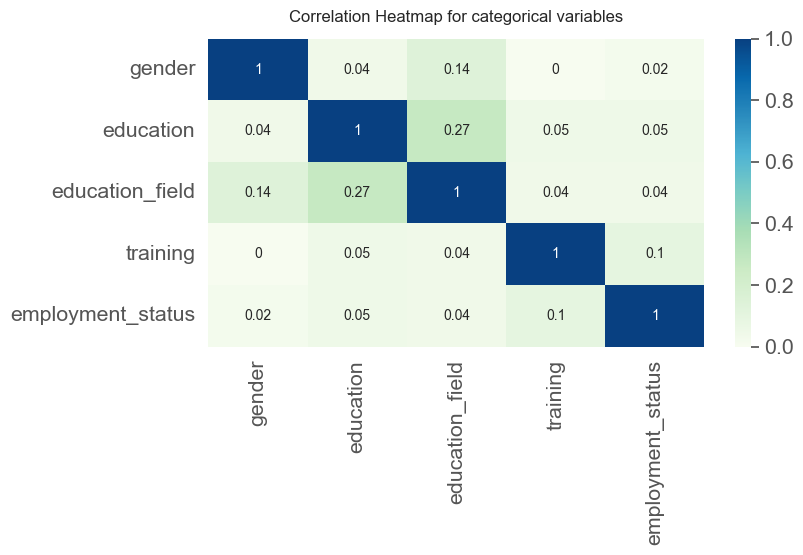

In [6611]:
create_heatmap(cramers_df, v_min = 0, v_max = 1, title = "Correlation Heatmap for categorical variables")

## Data cleaning and feature engineering


During the feature engineering process, label encoding as well as one-hot encoding will be performed. In addition, duplicates will be removed and missing values will be replaced using the appropriate imputation method.

The attributes `gender`, `education`, `education_field`, `training` and `employment_status` are object data type i.e. categorical type.

### Label encoding

For the `education`, `gender` and `employment_status` variables the label encoding will be applied.

##### Gender

In [6612]:
enc = OrdinalEncoder()

data[['gender']] = enc.fit_transform(data[['gender']])

##### Education

In [6613]:
data.education.unique()

array(['upper secondary or post-secondary education',
       'basic vocational education', 'tertiary education',
       'primary or lower secondary education'], dtype=object)

In [6614]:
education_levels = ['primary or lower secondary education',
                    'basic vocational education',
                    'upper secondary or post-secondary education',
                    'tertiary education']

edu_enc = OrdinalEncoder(categories = [education_levels])

data["education"] = edu_enc.fit_transform(data[["education"]])

##### Employment status

In [6615]:
emp_statuses = ['unemployed',
                'employed']

emp_enc = OrdinalEncoder(categories = [emp_statuses])

data["employment_status"] = emp_enc.fit_transform(data[["employment_status"]])

In [6616]:
data.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,education_field,training,employment_status
0,5.666666,3.333333,6.0,3.666667,4.666666,23,1.0,2.0,general programmes,training in the 12 months prior to the postPIAAC,1.0
1,7.000000,4.000000,4.0,4.000000,4.000000,33,1.0,1.0,"engineering, manufacturing and construction",no training in the 12 months prior to the study,1.0


### One-Hot Encoding

As the `education_field` and `training` variable contains more categories, One Hot Encoding will be used in this case.

In [6617]:
data.columns

Index(['conscientiousness', 'extroversion', 'agreeableness', 'openness',
       'neuroticism', 'age', 'gender', 'education', 'education_field',
       'training', 'employment_status'],
      dtype='object')

In [6618]:
data = pd.get_dummies(data, columns = ["education_field"])
data.drop("education_field_no education", axis = 1, inplace = True)

In [6619]:
data = pd.get_dummies(data, columns = ["training"], drop_first=True)

In [6620]:
data.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,employment_status,education_field_agriculture and veterinary,...,education_field_general programmes,education_field_health and welfare,"education_field_humanities, languages and arts","education_field_science, mathematics and computing",education_field_services,"education_field_social sciences, business and law",education_field_teacher training and education science,training_training both in the 12 months prior to the PIAAC and postPIAAC,training_training in the 12 months prior to the PIAAC,training_training in the 12 months prior to the postPIAAC
0,5.666666,3.333333,6.0,3.666667,4.666666,23,1.0,2.0,1.0,0,...,1,0,0,0,0,0,0,0,0,1
1,7.000000,4.000000,4.0,4.000000,4.000000,33,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


### Data cleaning

As `age` can have a non-linear relationship on the independent variable, it was decided to create an `age_squared` variable to explore this.

In [6621]:
age_squared = data.age**2

data.insert(6, 'age_squared', age_squared)

In [6622]:
data[personality_cols] = data[personality_cols].round(decimals = 1)

Logistic regression cannot handle missing values well. Let's see in which columns they occur:

In [6623]:
data.isna().sum()

conscientiousness                                                           235
extroversion                                                                273
agreeableness                                                               246
openness                                                                    304
neuroticism                                                                 262
age                                                                           0
age_squared                                                                   0
gender                                                                        0
education                                                                     0
employment_status                                                             0
education_field_agriculture and veterinary                                    0
education_field_engineering, manufacturing and construction                   0
education_field_general programmes      

As the analyzed sample is relatively small and the missing data are present for variables related to the personality traits, in order not to lose too much information, it was decided to use the imputation method for replacing missing data. 

In [6624]:
imputer = SimpleImputer(strategy="median")
imputer.fit(data)

X = imputer.transform(data)
data = pd.DataFrame(X, columns = data.columns, index = data.index)

print(f"Number of NaN's in the given sample: {data.isna().sum().sum()}")

Number of NaN's in the given sample: 0


Now let's see whether we have any duplicates in the dataset:

In [6625]:
data.duplicated().sum()

10

In [6626]:
data.drop_duplicates(inplace = True)

print(f"Number of duplicates in the given sample: {data.duplicated().sum()}")

Number of duplicates in the given sample: 0


## Train-Test Split

The dataset will be divided into two subsets: train and test.

As the sample size in this study is relatively small, in order not to introduce sampling bias, the data will be divided using a stratified sampling method. Based on the literature, education is known to be important attribute in predicting employment status. A stratified sampling method will ensure that the test set is representative of the whole population and contains the same fraction of observations from each category of education variable as the training set.

In [6627]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, test_index in split.split(data, data["education"]):
    train_set = data.iloc[train_index]
    test_set = data.iloc[test_index]

print(f"Number of observations in the training set: {train_set.shape[0]}")
print(f"""
Percentage of observations from each category for the education variable in the training set: 
{train_set.education.value_counts()/train_set.shape[0]}
""")

print(f"Number of observations in the test set: {test_set.shape[0]}")
print(f"""
Percentage of observations from each category for the education variable in the test set: 
{test_set.education.value_counts()/test_set.shape[0]}
""")

Number of observations in the training set: 3954

Percentage of observations from each category for the education variable in the training set: 
2.0    0.387203
3.0    0.358118
1.0    0.177289
0.0    0.077390
Name: education, dtype: float64

Number of observations in the test set: 989

Percentage of observations from each category for the education variable in the test set: 
2.0    0.387260
3.0    0.357937
1.0    0.176946
0.0    0.077856
Name: education, dtype: float64



## Feature scaling

At this stage of the analysis, we'll standardize the data in order to prevent features with wider ranges from dominating the distance metric.


Let's standarize all the continuous variables:

In [6628]:
train_numcols = train_set[train_set.columns[:7]]
test_numcols = test_set[test_set.columns[:7]]

Get scaling parameters with the train sample and then scale both datasets:

In [6629]:
scale=StandardScaler()
scale.fit(train_numcols)

df_train_scaled = pd.DataFrame(scale.transform(train_numcols), columns = train_numcols.columns)
df_test_scaled = pd.DataFrame(scale.transform(test_numcols), columns = test_numcols.columns)

In [6630]:
df_train_scaled.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared
0,1.316459,2.451382,-0.341692,1.818547,-0.314364,-0.607076,-0.601423
1,-0.741614,0.199106,-1.278750,-0.318424,0.981941,-0.821645,-0.719337


In [6631]:
df_test_scaled.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared
0,-0.021289,0.574485,0.876484,-0.039688,-0.881497,-0.392507,-0.467056
1,-1.461940,-1.020877,0.876484,-0.690071,-0.071307,-0.964690,-0.788805


Insert columns with scaled values into the datasets:

In [6632]:
def insert_scaled_values(numcols, set, df_scaled):
    for col in numcols:
        set[col] = df_scaled[col].values

In [6633]:
insert_scaled_values(train_numcols, train_set, df_train_scaled)
insert_scaled_values(test_numcols, test_set, df_test_scaled)

## Handling imbalanced data using SMOTE

As we have seen above on the graph, the outcome variable in this study is imbalanced - there's much more people who were employed during postPIAAC study than unemployed. To solve this inconvenience, having in mind that the analyzed sample is relatively small, we will use SMOTE algorithm (synthetic minority oversampling technique) and perform oversampling. SMOTE synthesises new minority instances between existing minority instances.

Firstly, let's specify the training dataset containing independent variables (X), and the one containing dependent variable (y).

In [6634]:
X_train = train_set.loc[:, train_set.columns != 'employment_status']
y_train = train_set.loc[:, train_set.columns == 'employment_status']

print("The shape of X_train: ", X_train.shape)
print("The shape of y_train: ", y_train.shape)

The shape of X_train:  (3954, 21)
The shape of y_train:  (3954, 1)


In [6635]:

print(f"Before OverSampling, counts of label '1' and '0': \n\n{y_train.value_counts()}\n")

oversample = SMOTE()
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)
  
print(f"After OverSampling, counts of label '1' and '0': \n\n{y_train_res.value_counts()}\n")


Before OverSampling, counts of label '1' and '0': 

employment_status
1.0                  2678
0.0                  1276
dtype: int64

After OverSampling, counts of label '1' and '0': 

employment_status
0.0                  2678
1.0                  2678
dtype: int64



## Multicollinearity check

As one of the assumptions for logistic regression is that there is no multicollinearity between the variables, before building the model we will calculate the variance inflation factor (VIF), which measures the correlation and strength of correlation between the predictor variables in a regression model. 

In [6636]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_res.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_res.values, i)
                          for i in range(len(X_train_res.columns))]
  
print(vif_data)

                                              feature        VIF
0                                   conscientiousness   1.194279
1                                        extroversion   1.081749
2                                       agreeableness   1.175289
3                                            openness   1.130283
4                                         neuroticism   1.097241
5                                                 age  75.899337
6                                         age_squared  73.329180
7                                              gender   2.076450
8                                           education   9.220397
9          education_field_agriculture and veterinary   1.320233
10  education_field_engineering, manufacturing and...   2.887116
11                 education_field_general programmes   2.462684
12                 education_field_health and welfare   1.353580
13     education_field_humanities, languages and arts   1.666995
14  education_field_scien

As can be seen above, most of the variables have a low VIF coefficient, with the exception of `age` and `age_squared`, but in this case the multicollinearity is justified, as `age_squared` is a deterministic non-linear function of `age`, so a high coefficient in this case is not a cause for concern.

However, the high VIF coefficient of the variable `education` is a bit puzzling. It will be included in the model at this point and a possible decision to exclude this variable from the model will be taken at a later stage of the analysis.

## Logistic Regression Model

Now let's fit the logistic regression model to the training dataset.

In [6637]:
classifier = LogisticRegression()
classifier.fit(X_train_res, y_train_res)

LogisticRegression()

And then test the model over the testing set.

In [6638]:
X_test = test_set.loc[:, test_set.columns != 'employment_status']
y_test = test_set.loc[:, test_set.columns == 'employment_status']

print("The shape of X_test: ", X_test.shape)
print("The shape of y_test: ", y_test.shape)

The shape of X_test:  (989, 21)
The shape of y_test:  (989, 1)


In [6639]:
y_pred = classifier.predict(X_test)

## Model Evaluation

Before looking at the coefficients of the model, let's look at how well the model is built to predict the output variable.

### Confusion matrix

Firstly, we will calculate the confusion matrix, which is the basic tool used to assess the quality of the classification. The confusion matrix is formed from the intersection of the predicted class and the actually observed class, so we have 4 cases:

- True-Positive (TP - true positive): positive prediction, positive class actually observed 
- True-Negative (TN - true negative): negative prediction, actually observed negative class
- False-Positive (FP - false positive): positive prediction, negative class actually observed
- False-Negative (FN): negative prediction, positive class actually observed

In [6640]:
cmatrix = confusion_matrix(y_test, y_pred)
df_cmatrix = pd.DataFrame(cmatrix, index = (0, 1), columns = (0, 1))

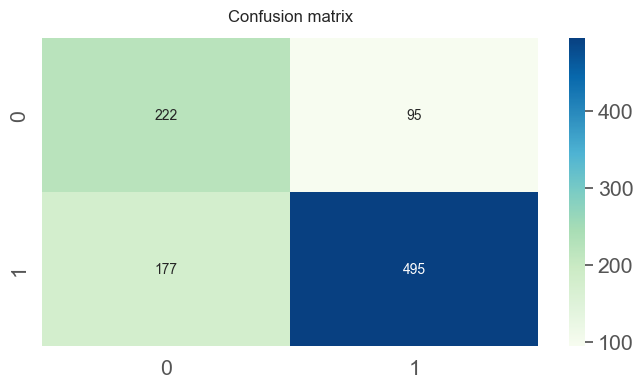

In [6641]:
create_heatmap(df_cmatrix, title = "Confusion matrix", set_fmt ='g')

As can be seen above in the confusion matrix, out of 989 observations, the model correctly classified 713 observations, while it performed an incorrect classification for 276 observations.

### Classification metrics

Now we'll have a look at the classification metrics:

In [6642]:
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.556391,0.700315,0.620112,317.000000
1.0,0.838983,0.736607,0.784469,672.000000
accuracy,0.724975,0.724975,0.724975,0.724975
macro avg,0.697687,0.718461,0.702290,989.000000
weighted avg,0.748405,0.724975,0.731788,989.000000


- Precision, also called positive predictive value, in our case is around 84% - if the model predicts that a respondent is employed, it's correct around 84% of the time.
- Recall (sensitivity) in our model is around 73% - for all the respondents that are actually employed, our model is able to identify around 73% of them.
- Accuracy, which measures how many observations, both positive and negative, were correctly classified for the given model is 72%.
- F1-score, which is the harmonic mean of the precision and recall, in our model is 78%, which is quite good.

### ROC Curve

Now we'll plot ROC Curve, which summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

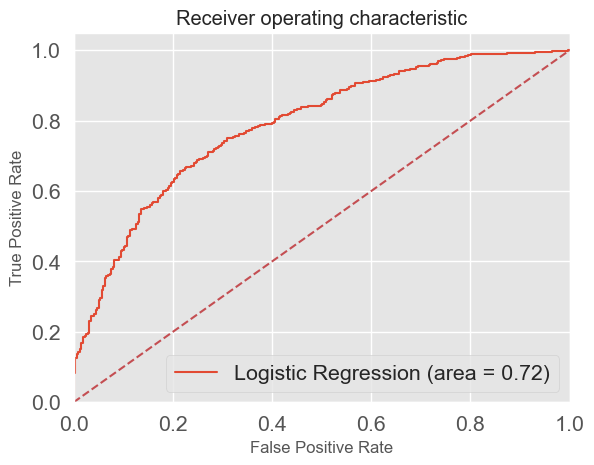

In [6643]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

plt.figure()
plt.style.use('ggplot')
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The more that the curve hugs the top left corner of the plot, the better the model does at classifying the data into categories. As we can see from the plot above and also looking at the AUC (area under the curve), we can conclude that there's 72% chance that the model will be able to distinguish between positive class and negative class, which is quite good.

## Analysing the coefficients

In [6644]:
from scipy.stats import norm
def logit_p1value(model, x):
   
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = (1 - norm.cdf(abs(t1))) * 2
    return p1

In [6645]:
# # source: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

# from sklearn import linear_model
# import numpy as np
# import scipy.stats as stat

# class LogisticRegression_with_p_values():
#     """
#     Wrapper Class for Logistic Regression which has the usual sklearn instance 
#     in an attribute self.model, and pvalues, z scores and estimated 
#     errors for each coefficient in 
    
#     self.z_scores
#     self.p_values
#     self.sigma_estimates
    
#     as well as the negative hessian of the log Likelihood (Fisher information)
    
#     self.F_ij
#     """
    
#     def __init__(self,*args,**kwargs):#,**kwargs):
#         self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

#     def fit(self,X,y):
#         self.model.fit(X,y)
#         #### Get p-values for the fitted model ####
#         denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
#         denom = np.tile(denom,(X.shape[1],1)).T
#         F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
#         Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
#         sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
#         z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
#         p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
#         self.z_scores = z_scores
#         self.p_values = p_values
#         self.sigma_estimates = sigma_estimates
#         self.F_ij = F_ij

#     # def predict(self,X):
#     #     self.model.predict(X)

In [6646]:
pvalue = list(map('{:.3f}'.format,logit_p1value(classifier, X_test)))

In [6648]:
pd.concat([pd.DataFrame(X_test.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"]),
           pd.DataFrame(pvalue, columns = ["p-value"])
           ],axis = 1)

,features,coef,p-value
0,conscientiousness,0.169247,0.000
1,extroversion,0.038667,0.041
2,agreeableness,-0.020973,0.613
3,openness,-0.050355,0.795
4,neuroticism,-0.082656,0.530
5,age,4.092601,0.285
6,age_squared,-4.519393,0.000
7,gender,0.776030,0.000
8,education,0.223631,0.000
9,education_field_agriculture and veterinary,1.007542,0.070
